In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
import pyDOE

torch.manual_seed(16)
np.random.seed(16)
#random.seed(16)
torch.backends.cudnn.deterministic = True

In [2]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN,self).__init__()
        #pde coefficients
        self.l = torch.nn.Parameter(torch.Tensor([0.5,0.5]))
        self.l.requires_grad = True
        
        #layer definitions
        self.FC1 = nn.Linear(1,50)
        self.act1 = nn.Tanh()
        
        self.FC2 = nn.Linear(50,50)
        self.act2 = nn.Tanh()
        
        self.FC3 = nn.Linear(50,50)
        self.act3 = nn.Tanh()
        
        self.FC4 = nn.Linear(50,1)

    def forward(self, x):
        #y  = torch.cat((x,t),1)
        x1 = self.FC1(x)
        x2 = self.act1(x1)
        x3 = self.FC2(x2)
        x4 = self.act2(x3)
        x5 = self.FC3(x4)
        x6 = self.act3(x5)
        x7 = self.FC4(x6)
        return x7

In [3]:
"""
real DE: y'' -2y' + y = 0
u(x) = e^x + xe^x
"""

Nf = 300

#design = pyDOE.lhs(1, samples = Nf)
#x = design[:,0]
x = np.linspace(-1,2,Nf)
f = np.zeros(Nf) #right hand side
u = np.exp(x) + x*np.exp(x)

x = x.reshape((-1, 1))
x = torch.tensor(x).type(torch.FloatTensor)
u = u.reshape((-1, 1))
u = torch.tensor(u).type(torch.FloatTensor)
f = f.reshape((-1, 1))
f = torch.tensor(f).type(torch.FloatTensor)

In [4]:
pn = PINN()

MAX_EPOCHS = 10000
LRATE = 1e-3

optimizer = torch.optim.Adam(pn.parameters(), lr=LRATE)
criterion = nn.MSELoss()

In [5]:
for epoch in range(MAX_EPOCHS):
    #full batch
    xc = x.clone()
    xc.requires_grad = True


    upred = pn(xc)
    upred_x = torch.autograd.grad(upred.sum(),xc,create_graph=True)[0]
    upred_xx = torch.autograd.grad(upred_x.sum(),xc,create_graph=True)[0]
    
    l0 = pn.l[0].clone()
    l1 = pn.l[1].clone()
    
    mse_u = criterion(input=upred, target = u )
    mse_f = criterion(input=upred_xx +l0*upred_x + l1*upred , target = f )

    loss = mse_u + mse_f
    
    #optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        
        
    if (epoch+1) % 100 == 0:
        print("Epoch: {}, MSE_u: {:.7f}, MSE_f: {:.7f}, MSE: {:.7f}, l0: {:.4f}, l1: {:.4f}".format((epoch+1), mse_u, mse_f, loss, l0, l1))

Epoch: 100, MSE_u: 17.3727436, MSE_f: 1.0237192, MSE: 18.3964634, l0: 0.5000, l1: 0.3734, l2: 0.3756
Epoch: 200, MSE_u: 11.3098793, MSE_f: 0.6743467, MSE: 11.9842262, l0: 0.5000, l1: 0.2401, l2: 0.2804
Epoch: 300, MSE_u: 8.8712769, MSE_f: 0.6418355, MSE: 9.5131121, l0: 0.5000, l1: 0.1182, l2: 0.2079
Epoch: 400, MSE_u: 6.6441545, MSE_f: 0.5684972, MSE: 7.2126517, l0: 0.5000, l1: 0.0021, l2: 0.1182
Epoch: 500, MSE_u: 4.9101176, MSE_f: 0.4437781, MSE: 5.3538957, l0: 0.5000, l1: -0.1085, l2: 0.0199
Epoch: 600, MSE_u: 3.6231136, MSE_f: 0.3309722, MSE: 3.9540858, l0: 0.5000, l1: -0.2066, l2: -0.0684
Epoch: 700, MSE_u: 2.6634982, MSE_f: 0.2457586, MSE: 2.9092567, l0: 0.5000, l1: -0.2940, l2: -0.1466
Epoch: 800, MSE_u: 1.9421592, MSE_f: 0.2374502, MSE: 2.1796093, l0: 0.5000, l1: -0.3720, l2: -0.2157
Epoch: 900, MSE_u: 1.4399476, MSE_f: 0.1333768, MSE: 1.5733244, l0: 0.5000, l1: -0.4414, l2: -0.2766
Epoch: 1000, MSE_u: 1.0348247, MSE_f: 0.1177152, MSE: 1.1525400, l0: 0.5000, l1: -0.5031, l2: -0

Epoch: 8200, MSE_u: 0.0059356, MSE_f: 0.0008533, MSE: 0.0067890, l0: 0.5000, l1: -0.9291, l2: -0.6241
Epoch: 8300, MSE_u: 0.0056202, MSE_f: 0.0029823, MSE: 0.0086025, l0: 0.5000, l1: -0.9300, l2: -0.6236
Epoch: 8400, MSE_u: 0.0058542, MSE_f: 0.0002208, MSE: 0.0060750, l0: 0.5000, l1: -0.9307, l2: -0.6228
Epoch: 8500, MSE_u: 0.0061616, MSE_f: 0.0096577, MSE: 0.0158194, l0: 0.5000, l1: -0.9310, l2: -0.6217
Epoch: 8600, MSE_u: 0.0066904, MSE_f: 0.0302366, MSE: 0.0369270, l0: 0.5000, l1: -0.9318, l2: -0.6212
Epoch: 8700, MSE_u: 0.0060119, MSE_f: 0.0014476, MSE: 0.0074595, l0: 0.5000, l1: -0.9321, l2: -0.6200
Epoch: 8800, MSE_u: 0.0060874, MSE_f: 0.0287300, MSE: 0.0348174, l0: 0.5000, l1: -0.9330, l2: -0.6195
Epoch: 8900, MSE_u: 0.0060867, MSE_f: 0.0018706, MSE: 0.0079573, l0: 0.5000, l1: -0.9328, l2: -0.6179
Epoch: 9000, MSE_u: 0.0057705, MSE_f: 0.0014020, MSE: 0.0071725, l0: 0.5000, l1: -0.9342, l2: -0.6178
Epoch: 9100, MSE_u: 0.0058577, MSE_f: 0.0003801, MSE: 0.0062378, l0: 0.5000, l1: -

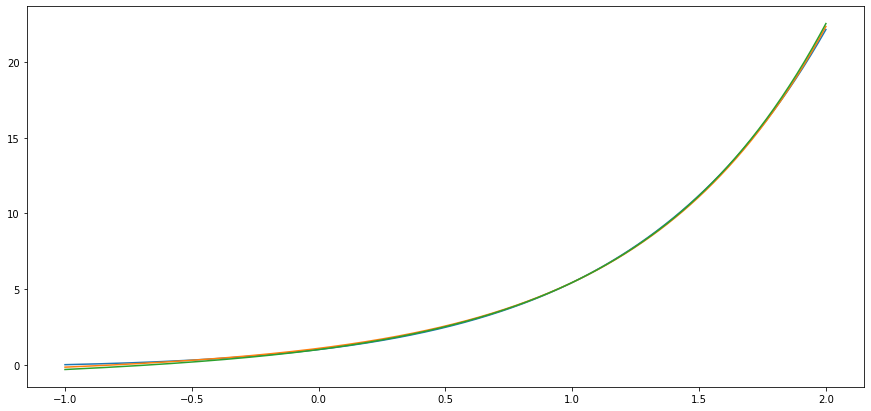

In [26]:
plt.rcParams["figure.figsize"] = (15,7)

x=np.linspace(-1,2,500)

y=[pn(torch.Tensor([i])).item() for i in x]

'''
u(x) e^x +xe^x
z = c1*np.exp((0.9394+np.sqrt(3.31847236))*x/2) + c2*np.exp((0.9394-np.sqrt(3.31847236))*x/2)

(1)
u(0) = z(0) =
c1 + c2 = 1

(2)
u(1) = 2e
z(1) = c1*3.977023731743245 + c2*0.6433066691964
     = c1*3.977023731743245 - c1*0.6433066691964 + 0.6433066691964 = 5.43656365691809
     =>c1 = 1.4378115772247952   &   c2 = -0.4378115772247952
'''

z=1.4378115772247952*np.exp((0.9394+np.sqrt(3.31847236))*x/2) - 0.4378115772247952*np.exp((0.9394-np.sqrt(3.31847236))*x/2)
u = np.exp(x) + x*np.exp(x)

plt.plot(x,u)
plt.plot(x,y)
plt.plot(x,z)